In [1]:
pip install gower

You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install scikit-learn-extra

You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install umap-learn

You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install prince

You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
import numpy as np

import gower

from prince import FAMD
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

from sklearn.cluster import DBSCAN
from sklearn_extra.cluster import KMedoids

from sklearn.metrics import silhouette_score, adjusted_mutual_info_score, adjusted_rand_score, calinski_harabasz_score, davies_bouldin_score

from sklearn import preprocessing
from collections import Counter
from sklearn.preprocessing import StandardScaler

import altair as alt
import matplotlib.pyplot as plt
%matplotlib inline

2022-10-24 06:13:54.782108: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-24 06:13:54.988588: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-10-24 06:13:54.992839: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-24 06:13:54.992854: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

### Please Note
This notebook is an exploration of possible improvements mentioned in the discussion section of the report. It mainly tries calculating similarity based on Gower distance for dimension reduction and clustering. Further improvement is needed.

#### Prepare vessel data

Excluded IMO, Vessel Name and Timeseen for result analysis since they are served as record identifies.

Vessel Type is also exclued due to it's highly imbalanced feature (99% of the type is the same type)  that we found during the EDA.

In [6]:
df_raw= pd.read_csv("data/cleansed/vessel_dwell_time.csv")

df = df_raw.copy()
#map bool to object
df['is_holiday'] = df['is_holiday'].map({True: 'true', False: 'false'})
df = df.drop(['imo', 'vessel_name', 'time_seen','vessel_type'], axis =1)

#convert dwell_in_hr to dwell range class 
bins = [0,24,48,72,96,120, df['dwell_in_hr'].max()]
names = ['0-24hr', '24-48hr', '48-72hr', '72-96hr', '96-120hr', '>120hr']
pd.cut(df['dwell_in_hr'], bins, labels=names)
df['dwell_label'] = pd.cut(df['dwell_in_hr'], bins, labels=names)

# convert age_range from category to object 
df['dwell_label'] = df['dwell_label'].astype('object')

X = df.drop(['dwell_in_hr','dwell_label'], axis = 1)
y = df['dwell_label']
X.head(3)

target_terminal  avg_dwell_at_target_terminal  \
0           PierT                          25.5   
1           PierT                          46.4   
2           PierA                          14.0   

   num_of_vessel_at_target_terminal  num_of_vessel_in_port  weekday  \
0                               1.0                   50.0        1   
1                               2.0                   53.0        6   
2                               0.0                   57.0        2   

   hour_of_day is_holiday vessel_operator  vessel_width  vessel_length  \
0           10      false          MAERSK          30.0          210.0   
1           10      false          MAERSK          30.0          210.0   
2            0      false          MATSON          32.0          262.0   

   vessel_dwt  
0     34677.0  
1     34677.0  
2     30825.0

### Calculate Gower distance
We use the Gower distance to transform and measure the similarity between different type of variables (numeric and categorical variables). Then doing clustering on PCA, t-SNE, and UMAP embeddings to compare the result.

Here vessel_operator is included. For other features, we keeps the same.
(we also exclude IMO, Vessel Name and Timeseen for result analysis since they are served as record identifies. Vessel Type is also exclued since it's highly imbalanced feature (99% of the type is the same type) that we found during the EDA.)



In [7]:
# compute Gower distance of input data
gower_dist_matrix = gower.gower_matrix(X)
# gower_dist_matrix.shape

In [8]:
#find top n similar records wiht the first record
topn = gower.gower_topn(X.iloc[0:1,:], X, n=5)
# show the similar 5 records as the first one
X.iloc[topn['index'],:]

target_terminal  avg_dwell_at_target_terminal  \
0             PierT                          25.5   
77            PierT                          23.9   
103           PierT                          12.2   
78            PierT                          18.4   
79            PierT                          55.1   

     num_of_vessel_at_target_terminal  num_of_vessel_in_port  weekday  \
0                                 1.0                   50.0        1   
77                                1.0                   46.0        1   
103                               1.0                   57.0        1   
78                                1.0                   50.0        1   
79                                1.0                   42.0        1   

     hour_of_day is_holiday vessel_operator  vessel_width  vessel_length  \
0             10      false          MAERSK          30.0          210.0   
77             9      false          MAERSK          30.0          208.0   
103            9      false          MAERSK          30.0          210.0   
78             6      false          MAERSK          30.0          208.0   
79             6      false          MAERSK          30.0          208.0   

     vessel_dwt  
0       34677.0  
77      34221.0  
103     34457.0  
78      34221.0  
79      34221.0

### Compare PCA, t-SNE, and UMAP embeddings


In [9]:
%%time
# PCA embeddings
X_pca = PCA(n_components = 2, random_state = 42).fit_transform(gower_dist_matrix)
df['pca_comp1'] = X_pca[:,0]
df['pca_comp2'] = X_pca[:,1]

CPU times: user 134 ms, sys: 280 ms, total: 414 ms
Wall time: 481 ms


In [10]:
%%time
# t-SNE embeddings
X_tsne = TSNE(n_components = 2, random_state = 42).fit_transform(gower_dist_matrix)
df['tsne_comp1'] = X_tsne[:,0]
df['tsne_comp2'] = X_tsne[:,1]

/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
CPU times: user 6.94 s, sys: 525 ms, total: 7.46 s
Wall time: 14.5 s


In [11]:
%%time
# UMAP embeddings
X_umap = umap.UMAP(n_components = 2, random_state = 42).fit_transform(gower_dist_matrix)
df['umap_comp1'] = X_umap[:,0]
df['umap_comp2'] = X_umap[:,1]

CPU times: user 9.46 s, sys: 276 ms, total: 9.74 s
Wall time: 19 s


In [12]:
# make a func to plot visualization
def plot_viz(df,col_x,col_y, col_color=None):
    if col_color == None:
        plt = alt.Chart(data=df).mark_circle(size=40).encode(
            x=col_x +':Q',
            y=col_y +':Q',
            # color=alt.Color(col_color +':N', scale=alt.Scale(scheme='dark2')),
            tooltip=[
                'target_terminal:N', 
                'avg_dwell_at_target_terminal:Q', 
                'num_of_vessel_at_target_terminal:Q', 
                'weekday:O', 
                'hour_of_day:O', 
                'is_holiday:N',
                'vessel_operator:N',
                'dwell_in_hr:Q'
            ]
        ).properties(
            width=500,
            height=500
        ).interactive()
    else:
        plt = alt.Chart(data=df).mark_circle(size=40).encode(
            x=col_x +':Q',
            y=col_y +':Q',
            color=alt.Color(col_color +':N', scale=alt.Scale(scheme='dark2')),
            tooltip=[
                'target_terminal:N', 
                'avg_dwell_at_target_terminal:Q', 
                'num_of_vessel_at_target_terminal:Q', 
                'weekday:O', 
                'hour_of_day:O', 
                'is_holiday:N',
                'vessel_operator:N',
                'dwell_in_hr:Q'
            ]
        ).properties(
            width=500,
            height=500
        ).interactive()
    
    return plt

In [13]:
plot_viz(df,'pca_comp1','pca_comp2')
# plot_viz(df,'pca_comp1','pca_comp2', 'dwell_label')

alt.Chart(...)

In [14]:
plot_viz(df,'tsne_comp1', 'tsne_comp2')
# plot_viz(df,'tsne_comp1', 'tsne_comp2', 'dwell_label')

alt.Chart(...)

In [15]:
plot_viz(df,'umap_comp1', 'umap_comp2')
# plot_viz(df,'umap_comp1', 'umap_comp2', 'dwell_label')

alt.Chart(...)

### Apply KMedoids clustering
<a id = https://www.researchgate.net/publication/327832223_Distance-based_clustering_of_mixed_data> Gower matrics should not combin with Kmeans from a geometric stand point.</a>
Gower matric works well with KMedois, which chooses actual data points as centers. It is more robust to noise and outliers than the K-means.

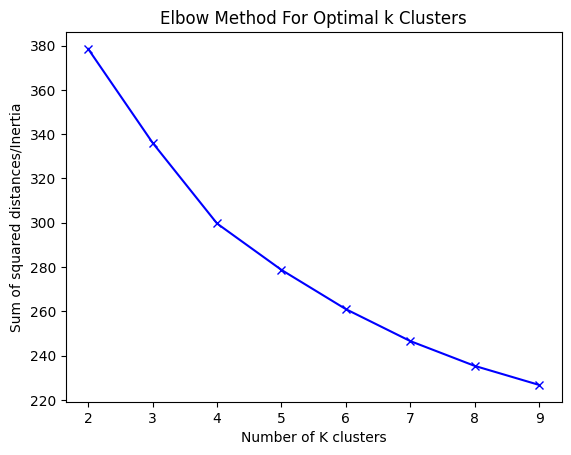

In [16]:
# find optimal num of clusters
Sum_of_squared_distances = []
K = range(2,10)
for num_clusters in K :
    gower_kmedoids_clusters = KMedoids(n_clusters=num_clusters, 
                        metric='precomputed',
                        method='pam', init='build', 
                        max_iter=300, 
                        random_state=42)
    gower_kmedoids_clusters.fit(gower_dist_matrix)
    Sum_of_squared_distances.append(gower_kmedoids_clusters.inertia_)
plt.plot(K,Sum_of_squared_distances,'bx-')
plt.xlabel('Number of K clusters') 
plt.ylabel('Sum of squared distances/Inertia') 
plt.title('Elbow Method For Optimal k Clusters')
plt.show()

In [17]:
Sum_of_squared_distances

[378.5033,
 336.10782,
 299.67535,
 278.72272,
 260.9967,
 246.57465,
 235.3739,
 226.77945]

Both k=4 and k=6 look good, let's get more insight from hierarchical clustering dendrogram plot.

In [18]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt

In [19]:
# helper functions to draw dendrogram and plot the clusters
def plot_dendrogram(data, p):
  # use dendrogram to find the optimal number of clusters
  plt.figure(figsize=(8,4))

  Z1 = linkage(data, 'ward')
  R = dendrogram(Z1, 
                truncate_mode = 'lastp', 
                p = p, 
                show_leaf_counts = False,
                show_contracted=True, # get a distribution impression in truncated branches
            )
  plt.title('Hierarchical Clustering Dendrogram (truncated)', fontsize=14)
  plt.xlabel('Vessels', fontsize=12)
  plt.ylabel('Distance', fontsize=12)
  plt.show()

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:6: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  


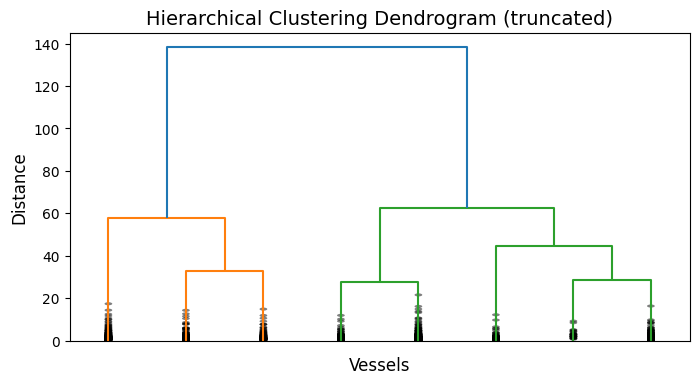

In [20]:
plot_dendrogram(gower_dist_matrix, 8)

As we can see, the distances for 4 clusters are more obivous than the distance for 6 clusters, which indicates 4 clusters would be better.

In [21]:
#  we choose 4 clusters
num_clusters = 4
gower_kmedoids_clusters = KMedoids(n_clusters=num_clusters, 
                           metric='precomputed',
                           method='pam', init='build', 
                           max_iter=300, 
                           random_state=42).fit(gower_dist_matrix)

In [22]:
df['kmedoids_pred'] = gower_kmedoids_clusters.labels_

In [23]:
plot_viz(df,'umap_comp1', 'umap_comp2', 'kmedoids_pred')

alt.Chart(...)

In [31]:
X.shape

(1634, 11)

### Apply DBSCAN clustering

In [32]:
# estimate optimal epsilon parameter by k-distances plot

from sklearn.neighbors import NearestNeighbors

neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(df[['umap_comp1', 'umap_comp2']])
distances, indices = nbrs.kneighbors(df[['umap_comp1', 'umap_comp2']])

distances = np.sort(distances, axis=0)
distances = distances[:,1]

df_distances = pd.DataFrame(distances, columns=['distances'])
df_distances = df_distances.reset_index()

In [33]:
alt.Chart(data=df_distances).mark_line().encode(
    x='index:Q',
    y='distances:Q'
).properties(
    width=600,
    height=400
).interactive()

alt.Chart(...)

In [36]:
# set dbscan model, parameters need to optimize later
dbscan = DBSCAN(eps = 0.1, min_samples = 10,metric = 'precomputed').fit(gower_dist_matrix)

# get the labels and see the distribution of each cluster
preds_label_gower_dbscan = dbscan.labels_
print(Counter(preds_label_gower_dbscan))
print('number of clusters: {}'.format(len(np.unique(preds_label_gower_dbscan))-1))

Counter({2: 367, 4: 305, 5: 296, -1: 266, 3: 164, 1: 148, 7: 38, 0: 36, 6: 14})
number of clusters: 8


In [37]:
df['dbscan_pred'] = preds_label_gower_dbscan

In [38]:
plot_viz(df,'umap_comp1', 'umap_comp2', 'dbscan_pred')

alt.Chart(...)

### Evaluate clustering performance

In [39]:
# evaluate clusters performance on different embeddings using silhouette score
def get_score_df(df):
    embeddings = [['pca_comp1', 'pca_comp2'], 
                    ['tsne_comp1','tsne_comp2'], ['umap_comp1', 'umap_comp2']]
    clusters = ['kmedoids_pred','dbscan_pred']

    scores=[]
    for i in embeddings:
        score_pair =[]
        for j in clusters:
            score = silhouette_score(df[i],df[j])
            score_pair.append(score)
        scores.append(score_pair)

    cols = ['PCA_embeddings', 't-SNE_embeddings','UMAP_embeddings']
    idx = ['KMedoids', 'DBSCAN']
    data_dict = dict(zip(cols,scores))
    score_df = pd.DataFrame(data = data_dict, index = idx)
    score_df = score_df.round(3)
    return score_df

In [40]:
score_df = get_score_df(df)
score_df

PCA_embeddings  t-SNE_embeddings  UMAP_embeddings
KMedoids           0.389             0.481            0.505
DBSCAN             0.158             0.232            0.215

Findings:

- UMAP outperforms t-SNE and PCA in preserving both global structure and local distances.
- Gower distance is a good metric for computing similarity between numerical and categorical variables.
- KMedoids is preferable to DBSCAN based on the silhouette score. With further research,one of the reason DBSCAN didn't work well is the parameter tunning. Another assumption is DBSCAN found more local structure such as the influences from different vessel operators might be captured more here.





<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=6b18b33d-3a56-4f49-ad6e-71ecea9f0183' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>